In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

In [2]:
## load in the preprocessed data and the sale prices for training data
data = pd.read_csv('Master_DF.csv')
data.set_index('Id', inplace=True)

In [3]:
# import raw training data and get log of prices
train_raw = pd.read_csv('train.csv')
train_raw.set_index('Id', inplace=True)
logprices = np.log10(train_raw.SalePrice)

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
columns = list(data.columns)

/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [5]:
scaled = pd.DataFrame(data_scaled, columns=columns)
scaled.index +=1
train = scaled.loc[1:1460,]
test = scaled.loc[1461:2919,]

In [6]:
outliers = list(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<300000)].index)
outliers

[524, 1299]

In [7]:
##Drop some of the correlated and categorical variables
dropcols = ['MSSubClass','MasVnrArea','TotalBsmtSF','LowQualFinSF','GrLivArea','TotRmsAbvGrd']
droprows = outliers
trim = scaled.drop(columns=dropcols)
trim = trim.drop(droprows)
trimprices = logprices.drop(droprows)

R squared: -5.183552814173978
Root Mean Squared Error: 20798.452312531288


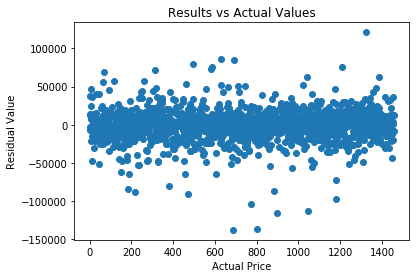

In [16]:
train = trim.loc[1:1460,]
test = trim.loc[1461:2919,]
linreg = LinearRegression()
linreg.fit(train, trimprices)
yhat = np.power(10, linreg.predict(train))
y = np.power(10, trimprices)
plt.scatter(range(len(y)),yhat-y)
plt.xlabel('Actual Price')
plt.ylabel('Residual Value')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat))
print("Root Mean Squared Error:",RMSE)

In [1]:
results = pd.Dataframe(y, yhat)
results.head()

NameError: name 'pd' is not defined

## Export to .csv for uploading

In [29]:
submission = pd.DataFrame({'Id':test.index, 'SalePrice': np.power(10, linreg.predict(test))})
submission.set_index('Id', inplace=True)
print(submission.head())
timestamp = datetime.now().strftime('%m-%d-%H-%M-%S')

      SalePrice
Id             
1461 120,660.24
1462 157,879.39
1463 176,978.19
1464 193,657.59
1465 187,562.99


In [19]:
submission.to_csv(f'submission_files/Sub{timestamp}.csv')